In [19]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

In [21]:
# Generating data
from generation import generate_from_total_pdf

N_events= 100000
dataset = generate_from_total_pdf(N_events, f=0.1, lam=0.5, mu=5.28, sigma=0.018)


the `UnbinnedNLL` is the -2 * log likelihood

Best to use parameters of order 1. (shld maybe change the sigma parameter to a different parameter of order 1). Eg. 100_times_sigma

This page explains the estimated uncertainty of the parameter estimates, by using the Hesse algorithm, and the Minos algorithm

https://iminuit.readthedocs.io/en/stable/notebooks/hesse_and_minos.html

Hesse "computes asymptotic errors", Minos "computes confidence intervals"


In [68]:


true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

random_shifts = {
    'f': np.random.uniform(-0.09, 0.5), 
    'lam': np.random.uniform(-0.3, 1), 
    'mu': np.random.uniform(-0.25, 0.3), 
    'sigma': np.random.uniform(-0.01, 0.03)
}

# starting parameters are true parameters with appropriate random shift
starting_params = {}
for param in true_params:
    # true parameter + some random shift
    starting_params[param] = true_params[param] + np.random.uniform(0, 1)*errors['error_'+param]

    # round to 4 significant figures
    starting_params[param] = float(f'{starting_params[param]:.4}')

starting_params

{'f': 0.3916, 'lam': 0.668, 'mu': 5.583, 'sigma': 0.03247}

In [69]:
from distributions import total_pdf

# Same as total_pdf except we add constant of 100 to the sigma parameter
# so that it is of order 1
def model(M, f, lam, mu, sigmaX100):
    sigma = sigmaX100/100
    return total_pdf(M, f, lam, mu, sigma)

alpha = 5
beta = 5.6

# Negative log likelihood as the cost function (actually -2 * log likelihood)
nll = UnbinnedNLL(dataset , total_pdf)

# Minimisation object
# Passing random starting values for the parameters
mi = Minuit(nll, **starting_params)

# adding constraints to the parameters
# some are physical constraints
# some are just 'sensible' constraints
mi.limits['f'] = (0, 1)
mi.limits['lam'] = (0, None)
mi.limits['sigma'] = (0, (beta-alpha)/2) # sigma shld defo not be any more than half the total space
mi.limits['mu'] = (alpha, beta)

# Minimise the cost function
mi.migrad()

# Hesse algorithm
mi.hesse()

# Minos algorithm
mi.minos()

# check if we found a valid minimum
print(mi.valid)

# print the fit result
print(mi)

True
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.095e+05                 │              Nfcn = 394              │
│ EDM = 2.06e-05 (Goal: 0.0002)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬

In [70]:

print(f'true params: {true_params}\n')
print(f'Starting params: {starting_params}\n')
print(mi.values)

true params: {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

Starting params: {'f': 0.3916, 'lam': 0.668, 'mu': 5.583, 'sigma': 0.03247}

<ValueView f=0.09791194186108321 lam=0.4940385813624566 mu=5.28015649447023 sigma=0.017733590864528293>


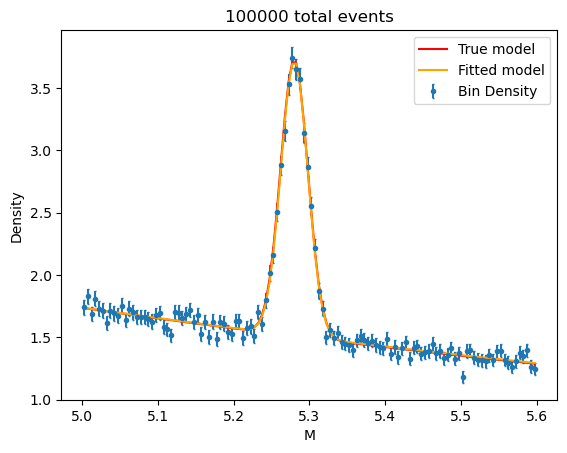

In [83]:
# Bin the events
bins = 120
bin_density, bin_edges = np.histogram(dataset, bins=bins, density=True)

# We calculate the actualy bin counts, in order to compute the errors
counts, _ = np.histogram(dataset, bins=bins, density=False)
count_uncertainties = np.sqrt(counts)
bin_widths = np.diff(bin_edges) # Calculate bin widths

# Normalize the uncertainties to convert them to density uncertainties
bin_err = count_uncertainties / (len(dataset) * bin_widths)

# Calculate bin midpoints
midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig, ax = plt.subplots()

# Plotting bin count vs midpoints
# ax.scatter(midpoints, bin_density, label='Binned events generated from Total PDF', marker='.')
ax.errorbar(midpoints, bin_density, yerr=bin_err, fmt='.', capsize=1, label='Bin Density')
ax.plot(midpoints, total_pdf(midpoints, **true_params), label='True model', color='red')
ax.plot(midpoints, total_pdf(midpoints, *mi.values), label='Fitted model', color='orange')

ax.set_xlabel('M')
ax.set_ylabel('Density')
ax.set_title(f'{N_events} total events')

ax.legend()

The cdf of the total PDF is given by the function defined below. In the report I will definitely have to justify this:

In [8]:
# def total_cdf(M, f, lam, mu, sigma):
#     alpha = 5
#     beta = 5.6

#     A = 1/(norm.cdf(x=beta, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))

#     B = 1/(expon.cdf(x=beta, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

#     signal_cdf = A*(norm.cdf(x=M, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))
#     background_cdf = B*(expon.cdf(x=M, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

#     return f*signal_cdf + (1-f)*background_cdf

In [9]:
# binned_nll = BinnedNLL(bin_counts, bin_edges, total_cdf)
# binned_mi = Minuit(
#     fcn = binned_nll,
#     f = 0.1,
#     lam = 0.5,
#     mu = 5.28,
#     sigma = 0.018,
# )

# # adding 'physical' constraints to the parameters
# mi.limits['f'] = (0, 1)
# mi.limits['lam'] = (0, None)
# mi.limits['sigma'] = (0, None)

# start = process_time()
# binned_mi.migrad()
# binned_mi.hesse()
# binned_mi.minos()
# stop = process_time()

# print ( " ++++ BINNED ++++ " )
# print ( binned_mi.params )
# print ( f" Took { stop - start :5.3} seconds ")

 ++++ BINNED ++++ 
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f     │   0.098   │   0.028   │   -0.027   │   0.030    │         │         │       │
│ 1 │ lam   │   0.51    │   0.33    │   -0.33    │    0.33    │         │         │       │
│ 2 │ mu    │   5.280   │   0.006   │   -0.006   │   0.006    │         │         │       │
│ 3 │ sigma │   0.018   │   0.006   │   -0.005   │   0.007    │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
 Took 0.112 seconds 


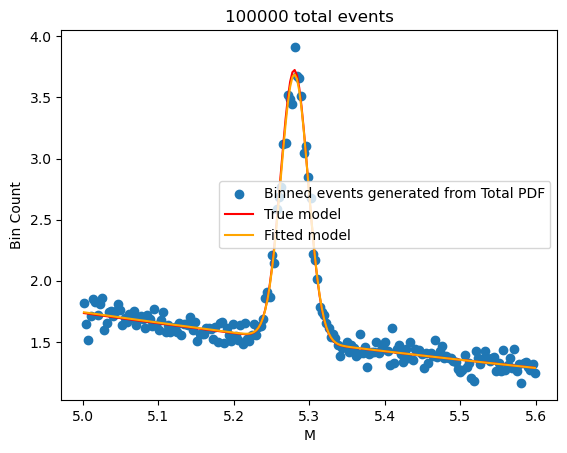

In [10]:
# fig, ax = plt.subplots()

# # Plotting bin count vs midpoints
# ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
# ax.plot(midpoints, model(midpoints, **true_params), label='True model', color='red')
# ax.plot(midpoints, model(midpoints, *binned_mi.values), label='Fitted model', color='orange')

# ax.set_xlabel('M')
# ax.set_ylabel('Bin Count')
# ax.set_title(f'{N_events} total events')

# ax.legend()